# Extracción de las coordenadas para cada tile de 500 x 500

Este código únicamente se encarga de comprobar de que las coordenadas para cada tile de 500 x 500 se conservan correctamente. Para ello, se extraen las coordenadas de cada tile y se grafican en un mapa.

In [2]:
from PIL import Image
import utils.img_fun as img_fun

import os
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from rasterio.transform import from_origin
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass


### Cargamos la imagen

In [51]:
NUM_TILE = 24

if os.path.exists('/content/drive/My Drive/doctorado_albert/conteo_pinguinos/'):
    path  = '/content/drive/My Drive/doctorado_albert/conteo_pinguinos/'
else:
    path = 'G:\\.shortcut-targets-by-id\\1pYgV5EIk4-LapLNhlCwpQaDAzuqNffXG\\doctorado_albert\\conteo_pinguinos'

image_name = f"recortes/recorte_{NUM_TILE}.tif"
tiff_file = os.path.join(path, image_name)


#! Verificamos la carga de la imagen (Solamente obtenemos información)
with rasterio.open(tiff_file) as src:
    print(f"Imagen cargada desde: {tiff_file}")
    print("Dimensiones: ", (src.width, src.height))
    print("Transformación de coordenadas: ", src.transform)
    print("Sistema de coordenadas: ", src.crs)


# Definimos las coordenadas del tile
img_info = img_fun.get_img_info(tiff_file)
min_x, max_y = img_info['top_left']
max_x, min_y = img_info['bottom_right']

Imagen cargada desde: G:\.shortcut-targets-by-id\1pYgV5EIk4-LapLNhlCwpQaDAzuqNffXG\doctorado_albert\conteo_pinguinos\recortes/recorte_24.tif
Dimensiones:  (10195, 11420)
Transformación de coordenadas:  | 0.00, 0.00,-59.23|
| 0.00,-0.00,-62.29|
| 0.00, 0.00, 1.00|
Sistema de coordenadas:  EPSG:4326


### Cargamos y leemos el csv o JSON con las coords

In [54]:
csv_file = os.path.join(path, 'chinstraps_eca56.csv')
data = pd.read_csv(csv_file, encoding='ISO-8859-1')

data.tail()

,Id,X,Y
36806,0,-59.229433,-62.306504
36807,0,-59.229478,-62.306502
36808,0,-59.229447,-62.306497
36809,0,-59.229484,-62.306495
36810,0,-59.229446,-62.306488


### Extraemos las coordenadas que están dentro del Tile en el que estamos trabajando

Para filtrar las coordenadas en tu archivo CSV y guardar solo aquellas que están dentro del área geográfica de un tile específico, necesitas seguir los siguientes pasos:

-Definir las coordenadas del tile: Obtén las coordenadas de las esquinas del tile que estás usando, que ya has calculado anteriormente.

-Filtrar las coordenadas: Compara las coordenadas del CSV con las del tile y guarda solo aquellas que estén dentro de los límites.


In [55]:
# Filtrar los puntos que están dentro del tile
filtered_data = data[
    (data['X'] <= min_x) & (data['X'] >= max_x) &
    (data['Y'] <= min_y) & (data['Y'] >= max_y)
]


filtered_data.to_csv(os.path.join('coords', 'coords_per_tile' ,f'coords_{NUM_TILE}.csv'), index=False)
filtered_data.head()

,Id,X,Y
4071,0,-59.225160,-62.290020
4072,0,-59.225171,-62.290025
4073,0,-59.225184,-62.290022
4074,0,-59.225195,-62.290021
4075,0,-59.225209,-62.290041


### Ejemplo de posibles resultados (para orientación)

*IMAGEN 62*

Esquina superior izquierda: (-59.236389267356785, -62.300974267474736)

Esquina superior derecha: (-59.231134009926784, -62.300974267474736)

Esquina inferior izquierda: (-59.236389267356785, -62.303714473634734)

Esquina inferior derecha: (-59.231134009926784, -62.303714473634734)

---

*IMAGEN 52*

Esquina superior izquierda: (-59.236389267356785, -62.29823406131474)

Esquina superior derecha: (-59.231134009926784, -62.29823406131474)

Esquina inferior izquierda: (-59.236389267356785, -62.300974267474736)

Esquina inferior derecha: (-59.231134009926784, -62.300974267474736)

### ⚠️⚠️⚠️ Hasta aquí. Con las exportación a csv de la celda anterior, es suficiente. ⚠️⚠️⚠️ -> pasar al notebook 3_AsginarNormalizarLabelsTxt

**Creamos un dataframe para guardar las coordenadas de cada cuadrado**

La siguiente celda va a crear un DATAFRAME que calculará la esquina superior izquierda y la esquina inferior derecha en torno a cada coordenada que le hayamos pasado. Ese dataframe, lo podemos usar posteriormente para dibujar un cuadrado en torno a cada punto.

In [13]:
# Inicializar una lista para almacenar los datos de los cuadrados
squares = []

# Definir el tamaño del cuadrado (15 píxeles de desplazamiento)
offset = 15

# Calcular las coordenadas de los cuadrados
for _, row in filtered_data.iterrows():
    x, y = row['X'], row['Y']

    # Convertir coordenadas geográficas a píxeles
    pixel_x, pixel_y = ~transform * (x, y)
    pixel_x, pixel_y = int(pixel_x), int(pixel_y)

    # Calcular las esquinas del cuadrado
    top_left = (pixel_x - offset, pixel_y - offset)  # Arriba izquierda
    bottom_right = (pixel_x + offset, pixel_y + offset)  # Abajo derecha

    # Agregar los datos del cuadrado a la lista
    squares.append({
        'Id': row['Id'],
        'Top_Left_X': top_left[0],
        'Top_Left_Y': top_left[1],
        'Bottom_Right_X': bottom_right[0],
        'Bottom_Right_Y': bottom_right[1]
    })

# Crear un DataFrame a partir de la lista de cuadrados
square_data = pd.DataFrame(squares)

# Mostrar el nuevo DataFrame
print(square_data.head())

    Id  Top_Left_X  Top_Left_Y  Bottom_Right_X  Bottom_Right_Y
0  0.0        8162        2931            8192            2961
1  0.0        8188        2948            8218            2978
2  0.0        8204        2923            8234            2953
3  0.0        8226        2950            8256            2980
4  0.0        8209        2972            8239            3002


### Pintamos un cuadrado en torno a square_data
---



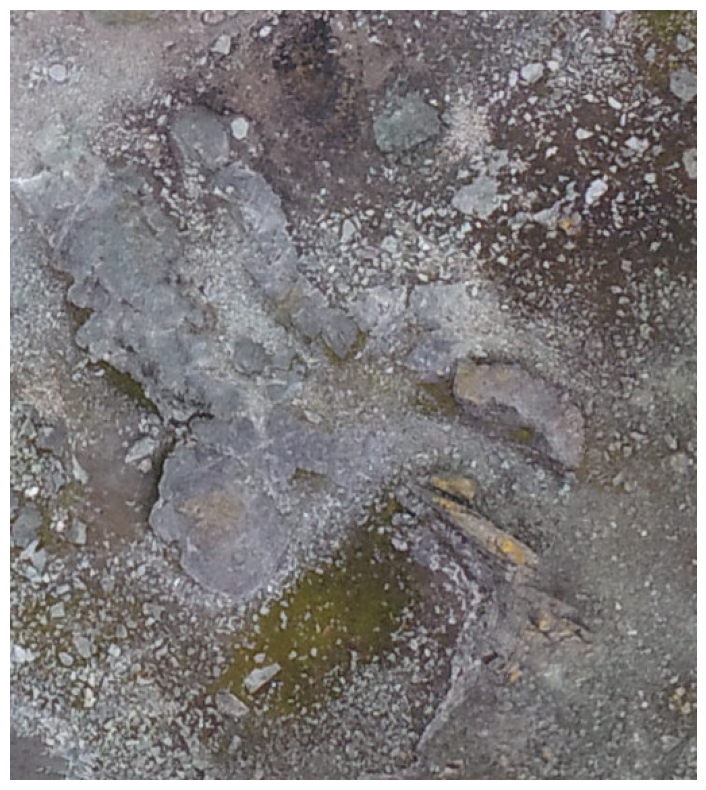

In [14]:
tile_name = f'tiles_500x500_{NUM_TILE}'
tiff_name = f'tile_{NUM_TILE}_subrecorte_396.tiff'
tiff_file = os.path.join('cut_tiles', tile_name, tiff_name)

with rasterio.open(tiff_file) as src:
    image = src.read()
    transform = src.transform

# Crear una copia de la imagen para modificarla
image_with_squares = image.copy()

# Pintar los bordes de los cuadrados en rojo
for _, row in square_data.iterrows():
    top_left_x = row['Top_Left_X']
    top_left_y = row['Top_Left_Y']
    bottom_right_x = row['Bottom_Right_X']
    bottom_right_y = row['Bottom_Right_Y']

    # Asegurarse de que las coordenadas estén dentro de los límites de la imagen
    top_left_x, top_left_y = int(top_left_x), int(top_left_y)
    bottom_right_x, bottom_right_y = int(bottom_right_x), int(bottom_right_y)

    if 0 <= top_left_x < image.shape[2] and 0 <= top_left_y < image.shape[1] and \
       0 <= bottom_right_x < image.shape[2] and 0 <= bottom_right_y < image.shape[1]:

        # Pintar los bordes en rojo (delimitados por píxeles)
        # Borde superior
        for x in range(top_left_x, bottom_right_x):
            image_with_squares[0, top_left_y, x] = 255  # R
            image_with_squares[1, top_left_y, x] = 0    # G
            image_with_squares[2, top_left_y, x] = 0    # B

        # Borde inferior
        for x in range(top_left_x, bottom_right_x):
            image_with_squares[0, bottom_right_y - 1, x] = 255  # R
            image_with_squares[1, bottom_right_y - 1, x] = 0    # G
            image_with_squares[2, bottom_right_y - 1, x] = 0    # B

        # Borde izquierdo
        for y in range(top_left_y, bottom_right_y):
            image_with_squares[0, y, top_left_x] = 255  # R
            image_with_squares[1, y, top_left_x] = 0    # G
            image_with_squares[2, y, top_left_x] = 0    # B

        # Borde derecho
        for y in range(top_left_y, bottom_right_y):
            image_with_squares[0, y, bottom_right_x - 1] = 255  # R
            image_with_squares[1, y, bottom_right_x - 1] = 0    # G
            image_with_squares[2, y, bottom_right_x - 1] = 0    # B

# Mostrar la imagen resultante
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(image_with_squares, (1, 2, 0)))  # Cambiar el orden para mostrar correctamente
plt.axis('off')  # Quitar los ejes
plt.show()


In [20]:
# Guardar la imagen modificada en el directorio especificado
output_image_path = os.path.join('square_maps', f'map_with_square_tile_{NUM_TILE}.tif')

# Guardar la imagen modificada en el directorio especificado
with rasterio.open(output_image_path, 'w', driver='GTiff', height=image_with_squares.shape[1],
                   width=image_with_squares.shape[2], count=image_with_squares.shape[0],
                   dtype=image_with_squares.dtype, crs=src.crs, transform=src.transform) as dst:
    dst.write(image_with_squares)

print(f"La imagen modificada se ha guardado como {output_image_path}")

RasterioIOError: Attempt to create new tiff file 'square_maps\map_with_square_tile_52.tif' failed: No such file or directory